In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [4]:
file_path = 'connect4_dataset.csv'
dataset = pd.read_csv(file_path)

dataset.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.32,0.33,0.34,-1,-1.1,0.35,0.36,1.1,1.2,0.37
0,0,0,0,0,0,0,0,1,0,0,...,1,0,1,1,-1,-1,0,-1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,-1,1,1,1,1,1,1,-1,-1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,-1,-1,-1,1,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,-1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,1,1,-1,-1,-1,1,0


In [13]:
# Preprocess data and train model
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

valid_indices = (y >= 0) & (y <= 6)
X = X[valid_indices]
y = y[valid_indices]

y = to_categorical(y, num_classes=7)

X = X.reshape(-1, 6, 7, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='tanh', padding='same', input_shape=(6, 7, 1)),
    BatchNormalization(),  # Normalize activations for stable training
    MaxPooling2D((2, 2), padding='same'),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='tanh', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    # Flatten and Dense layers
    Flatten(),
    Dense(64, activation='tanh'),  # Reduced dense layer size
    Dropout(0.5),  # Regularization
    Dense(7, activation='softmax')  # Output layer for 7 possible moves
])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Learning curve computation
def compute_learning_curve(model, X_train, X_test, y_train, y_test):
    train_sizes = [5000, 10000, 20000, 40000, 60000, 80000, 100000]
    train_accuracies = []
    test_accuracies = []

    for size in train_sizes:
        X_train_subset = X_train[:size]
        y_train_subset = y_train[:size]

        model.fit(X_train_subset, y_train_subset, epochs=5, batch_size=64, verbose=0)

        train_accuracy = model.evaluate(X_train_subset, y_train_subset, verbose=0)[1]
        test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_sizes, train_accuracies, test_accuracies

In [15]:
#Train the CNN Model
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_sizes, cnn_train_acc, cnn_test_acc = compute_learning_curve(model, X_train, X_test, y_train, y_test)

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8447 - loss: 0.4879
Test Accuracy: 84.74%


In [17]:
# Save the trained model to a file
model.save("connect4_cnn_model.h5")

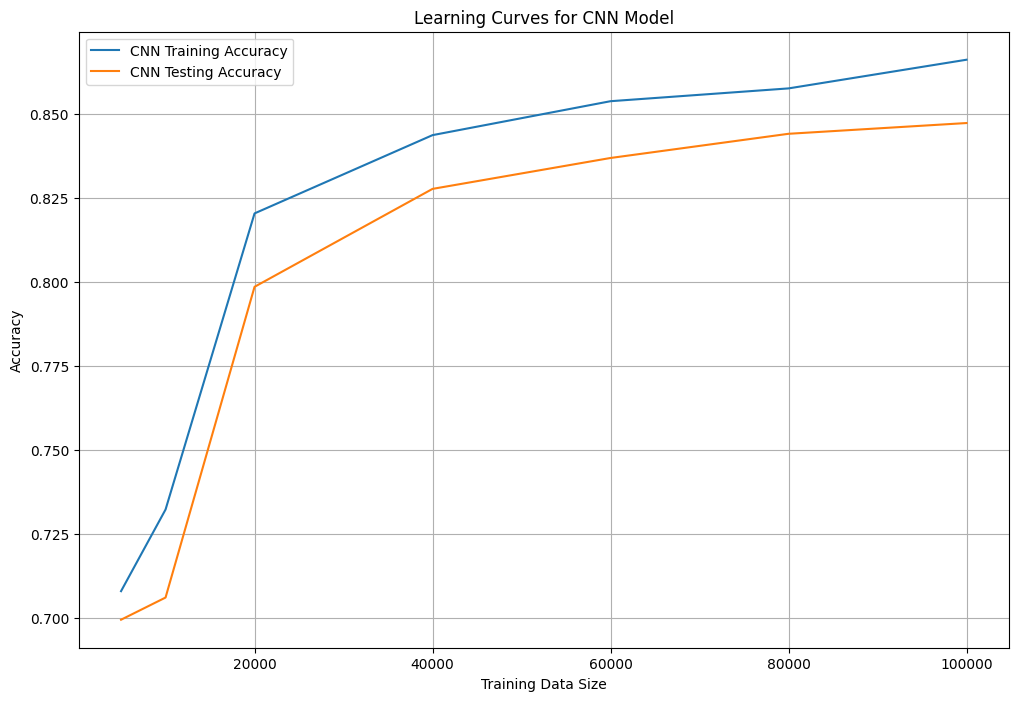

In [21]:
# Plot learning curves
plt.figure(figsize=(12, 8))
plt.plot(cnn_sizes, cnn_train_acc, label="CNN Training Accuracy")
plt.plot(cnn_sizes, cnn_test_acc, label="CNN Testing Accuracy")
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Learning Curves for CNN Model")
plt.legend()
plt.grid()
plt.show()